In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils

## read  first image and get mask for red and white

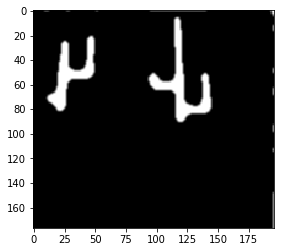

In [2]:
img= cv2.imread('images/coralcolony.jpg')
img_hsv=np.copy(img)
img_hsv = cv2.cvtColor(img_hsv , cv2.COLOR_BGR2HSV)

L = np.array([0,0,170], dtype=np.uint8)
U=np.array([155,111,255], dtype=np.uint8)
mask = cv2.inRange(img_hsv, L,U)

mask = cv2.medianBlur(mask,7)
mask= cv2.GaussianBlur(mask,(3,3),0)
h,w,_= img.shape
plt.imshow(mask, cmap='gray')

## read  first image and get mask for red and white

(177, 196, 3)


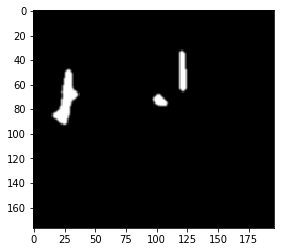

In [3]:
img2= cv2.imread('images/coralcolony2.jpg')
img2= cv2.resize(img2, (w,h), interpolation = cv2.INTER_AREA)

img2_hsv=np.copy(img2)
img2_copy= np.copy(img2)
img2_hsv = cv2.cvtColor(img2_hsv , cv2.COLOR_BGR2HSV)

L = np.array([50,20,180], dtype=np.uint8)
U=np.array([150,110,255], dtype=np.uint8)
mask2_white = cv2.inRange(img2_hsv, L,U)

mask2_white= cv2.medianBlur(mask2_white,7)
mask2_white = cv2.GaussianBlur(mask2_white,(3,3),0)
plt.imshow(mask2_white, cmap='gray')
print(img2.shape)

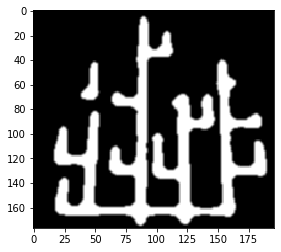

In [8]:
Lred2 =np.array([111,58,128])
Ured2 = np.array([255,255,255])
mask2_red= cv2.inRange(img2_hsv,Lred2,Ured2)
mask2_red= cv2.medianBlur(mask2_red,7)
mask2_red = cv2.GaussianBlur(mask2_red,(3,3),0)
plt.imshow(mask2_red, cmap='gray')

## extract feature using SIFT

In [4]:
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.7*n.distance: ## determine good matches 
        good.append(m)
        


## apply homography to the first image

In [5]:
MIN_MATCH =10

if len(good)>MIN_MATCH:

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, MASK = cv2.findHomography(src_pts,dst_pts,cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w,_ = img.shape
    im_out = cv2.warpPerspective(img, M, (img2.shape[1],img2.shape[0]))
    out = cv2.subtract (im_out, img2)
    
else:
    print('not enough matches')
 

## get the mask for red and white after homography for the first imgage

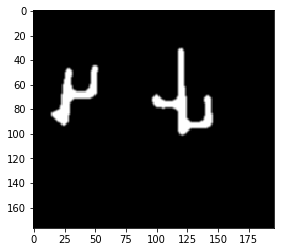

In [6]:
im_out_white= np.copy(im_out)
im_out_white= cv2.cvtColor(im_out, cv2.COLOR_BGR2HSV)
im_out_white= cv2.inRange(im_out_white,L,U)
im_out_white= cv2.medianBlur(im_out_white,7)
im_out_white = cv2.GaussianBlur(im_out_white,(3,3),0)

kernel = np.ones((5,5), np.uint8)

plt.imshow(im_out_white,cmap='gray')

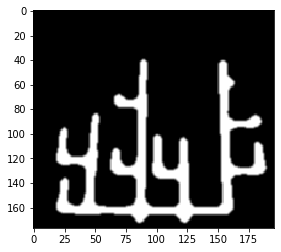

In [7]:
Lred =np.array([120,83,118])
Ured = np.array([255,255,255])
im_out_red= np.copy(im_out)
im_out_red=cv2.cvtColor(im_out, cv2.COLOR_BGR2HSV)
im_out_red= cv2.inRange(im_out_red,Lred,Ured)
im_out_red= cv2.medianBlur(im_out_red,7)
im_out_red = cv2.GaussianBlur(im_out_red,(3,3),0)
plt.imshow(im_out_red, cmap='gray')

## function to draw rectangle around difference areas

In [9]:
def get_rectangle(img , color):
    _,contours,_ = cv2.findContours(img,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        area = cv2.contourArea(c)
        if area > 100:
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(img2_copy, (x, y), (x + w, y + h), color, 2)
    return img2_copy

## get difference through bitwise operation between masks for each color in the images

In [10]:
def difference(im_out_white,im_out_red,mask2_white,mask2_red):
    kernel = np.ones((5,5),np.uint8)
    and_im_out = cv2.bitwise_or(im_out_white,im_out_red)
    and_img2= cv2.bitwise_or(mask2_white,mask2_red)
    xor_red= cv2.bitwise_xor(and_im_out,and_img2)
    xor_red = cv2.morphologyEx(xor_red , cv2.MORPH_OPEN ,kernel)

    growth= cv2.bitwise_and(xor_red,mask2_red)
    change= get_rectangle(growth,(0, 255,0))
    
    damage = cv2.bitwise_and(xor_red,im_out_red)
    change = get_rectangle(damage,(0,255,200))
    
    xor_white = cv2.bitwise_xor(mask2_white,im_out_white)
    xor_white = cv2.morphologyEx(xor_white , cv2.MORPH_OPEN ,kernel)
    
    recovery = cv2.bitwise_and(xor_white,mask2_red)
    change = get_rectangle(recovery,(255,0,0))
    
    bleach = cv2.bitwise_and(xor_white,im_out_red)
    change = get_rectangle(bleach,(0,0,255))
    return change

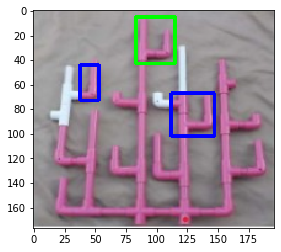

In [11]:
diff = difference(im_out_white,im_out_red,mask2_white,mask2_red)
plt.imshow(imutils.opencv2matplotlib(diff))